## Import

In [1]:
import pandas as pd
import numpy as np
# W2V
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
# visualize
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read data

In [2]:
data = pd.read_parquet('../data/DC_230910_final.pqt')
data.head()

,age,gender,tran_date,tran_time,play_date,play_st_time,price,ticket_cancel,discount_type,pre_open_date,...,좌석번호,seat_label,origin_price,seat_grade,prices,n_grade,공연명,선예매여부,선예매기간,공연요일
0,50.0,F,2022-01-14,1512,2022-02-04,2000,10000,1,일반,2022-01-14,...,10,1936,10000.0,B,"[120000.0, 90000.0, 50000.0, 10000.0]",4.0,None,1.0,1.0,4.0
1,60.0,F,2020-01-16,38,2020-02-11,1930,30000,0,일반,2019-12-20,...,10,1936,30000.0,B,"[120000.0, 90000.0, 60000.0, 30000.0]",4.0,None,1.0,3.0,1.0
2,NaN,None,2019-09-09,1253,2019-10-15,2000,0,0,초대권,NaT,...,10,1936,0.0,None,"[150000.0, 120000.0, 100000.0, 80000.0]",4.0,제 16회 차이콥스키 콩쿠르 우승자 갈라콘서트,0.0,NaN,1.0
3,NaN,None,2019-03-08,1447,2019-03-22,2000,0,0,초대권,2019-03-03,...,10,1936,NaN,None,None,NaN,None,NaN,NaN,NaN
4,20.0,F,2023-04-29,1322,2023-05-23,1930,24000,0,가정의 달 특별할인(8매/4.28까지)20%,2023-02-25,...,10,1936,30000.0,B,"[110000.0, 90000.0, 60000.0, 30000.0]",4.0,코리아남성합창단 제22회 정기연주회,1.0,1.0,1.0


In [3]:
feature = pd.read_parquet('../data/performance.pqt')

## Feature Generation

In [4]:
feature['play_st_time'] = feature['play_st_time']//100

# 결측치는 선예매를 운영하지 않은 공연으로 -1로 대체한다.
feature['선예매기간'].fillna(-1, inplace=True)

feature.drop(['pre_open_date','grade'], axis=1, inplace=True)
feature

,genre,play_date,prices,n_grade,공연명,play_st_time,open_date,running_time,intermission,선예매여부,선예매기간,공연요일
performance_label,,,,,,,,,,,,
0,교향곡,2022-02-04,"[120000.0, 90000.0, 50000.0, 10000.0]",4,None,20,2022-01-15,120,15,1,1.0,4
1,독주,2022-03-02,"[180000.0, 140000.0, 110000.0, 70000.0]",4,"국립합창단 기획공연 위대한 합창 시리즈Ⅰ- 칼 오르프, 카르미나 부라나",19,2022-01-10,90,0,1,1.0,2
2,교향곡,2019-03-23,"[350000.0, 260000.0, 180000.0, 120000.0, 70000.0]",5,오페라 카니발 2019,20,2018-11-19,100,15,1,0.0,5
4,교향곡,2019-07-23,"[150000.0, 120000.0, 80000.0, 30000.0, 20000.0]",5,제17회 코리아니쉬 플루트 오케스트라 정기연주회,20,2019-06-02,120,20,1,0.0,1
5,교향곡,2022-06-29,"[80000.0, 60000.0, 20000.0]",3,<강남심포니오케스트라 제92회 정기연주회>,19,2022-04-30,110,15,1,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
458,독주,2022-11-25,"[70000.0, 50000.0, 30000.0]",3,None,19,2022-08-21,100,20,1,1.0,4
540,성악,2021-08-28,"[150000.0, 120000.0, 100000.0, 70000.0, 50000.0]",5,None,19,2021-06-20,140,10,1,1.0,5
634,독주,2022-10-15,"[110000.0, 90000.0, 70000.0, 50000.0]",4,None,17,2022-08-21,70,0,1,1.0,5


- 공연일 년도, 월

In [5]:
feature['play_year'] =  feature['play_date'].dt.year
feature['play_month'] = feature['play_date'].dt.month

- 예매시작일 월

In [6]:
feature['open_month'] = feature['open_date'].dt.month

- 공연과 예매가능일 차이

In [7]:
feature['date_gap'] = (feature['play_date'] - feature['open_date']).dt.days
feature.drop(['play_date','open_date'], axis=1, inplace=True)

- 좌석등급별 가격

In [8]:
ease = pd.DataFrame([i.tolist()+[0]*(5-i.shape[0]) for i in feature.prices], 
                    index=feature.index, columns=[f'G{i}' for i in range(1,6)])
feature = pd.concat([feature, ease//1000], axis=1).drop('prices', axis=1)
feature

,genre,n_grade,공연명,play_st_time,running_time,intermission,선예매여부,선예매기간,공연요일,play_year,play_month,open_month,date_gap,G1,G2,G3,G4,G5
performance_label,,,,,,,,,,,,,,,,,,
0,교향곡,4,None,20,120,15,1,1.0,4,2022,2,1,20,120.0,90.0,50.0,10.0,0.0
1,독주,4,"국립합창단 기획공연 위대한 합창 시리즈Ⅰ- 칼 오르프, 카르미나 부라나",19,90,0,1,1.0,2,2022,3,1,51,180.0,140.0,110.0,70.0,0.0
2,교향곡,5,오페라 카니발 2019,20,100,15,1,0.0,5,2019,3,11,124,350.0,260.0,180.0,120.0,70.0
4,교향곡,5,제17회 코리아니쉬 플루트 오케스트라 정기연주회,20,120,20,1,0.0,1,2019,7,6,51,150.0,120.0,80.0,30.0,20.0
5,교향곡,3,<강남심포니오케스트라 제92회 정기연주회>,19,110,15,1,0.0,2,2022,6,4,60,80.0,60.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,독주,3,None,19,100,20,1,1.0,4,2022,11,8,96,70.0,50.0,30.0,0.0,0.0
540,성악,5,None,19,140,10,1,1.0,5,2021,8,6,69,150.0,120.0,100.0,70.0,50.0
634,독주,4,None,17,70,0,1,1.0,5,2022,10,8,55,110.0,90.0,70.0,50.0,0.0


- 동일장르 최근 5개 공연의 전년도 평균매출

In [9]:
# 전월로 하고싶은데 ㅠ 연결이 안됨
data['play_year'] = data['play_date'].dt.year

In [10]:
mean = data.groupby(['play_year','performance_label','genre'])[['price','origin_price']].mean()
mean = mean.reset_index().groupby(['play_year','genre'])[['price','origin_price']].mean()\
       .rename(columns={'price':'전년도실제매출','origin_price':'전년도정가매출'})

In [11]:
feature = feature.reset_index().merge(mean.reset_index(), on=['play_year','genre'])
feature = feature.set_index('performance_label').sort_index()
feature

,genre,n_grade,공연명,play_st_time,running_time,intermission,선예매여부,선예매기간,공연요일,play_year,play_month,open_month,date_gap,G1,G2,G3,G4,G5,전년도실제매출,전년도정가매출
performance_label,,,,,,,,,,,,,,,,,,,,
0,교향곡,4,None,20,120,15,1,1.0,4,2022,2,1,20,120.0,90.0,50.0,10.0,0.0,30732.887682,46253.585640
1,독주,4,"국립합창단 기획공연 위대한 합창 시리즈Ⅰ- 칼 오르프, 카르미나 부라나",19,90,0,1,1.0,2,2022,3,1,51,180.0,140.0,110.0,70.0,0.0,66503.614172,75066.631378
2,교향곡,5,오페라 카니발 2019,20,100,15,1,0.0,5,2019,3,11,124,350.0,260.0,180.0,120.0,70.0,19917.525349,35313.979321
4,교향곡,5,제17회 코리아니쉬 플루트 오케스트라 정기연주회,20,120,20,1,0.0,1,2019,7,6,51,150.0,120.0,80.0,30.0,20.0,19917.525349,35313.979321
5,교향곡,3,<강남심포니오케스트라 제92회 정기연주회>,19,110,15,1,0.0,2,2022,6,4,60,80.0,60.0,20.0,0.0,0.0,30732.887682,46253.585640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,교향곡,4,어버이날 특별 음악회 - 조수미 콘서트 <나의 어머니>,17,120,15,0,-1.0,5,2021,5,1,127,80.0,60.0,30.0,10.0,0.0,29824.595673,40609.128434
689,독주,3,클라라 주미 강 ＆ 김선욱 베토벤 바이올린 소나타 전곡,19,100,15,0,-1.0,1,2021,9,8,23,110.0,90.0,70.0,0.0,0.0,65009.326242,85543.993034
690,성악,4,None,19,150,20,1,1.0,4,2021,7,6,25,121.0,110.0,88.0,66.0,0.0,32985.246527,73058.469284


- 공연명 Word2Vec

In [12]:
feature['공연명전처리'] = feature['공연명'].str.replace(pat=r'[^A-Za-z0-9가-힣\.]',repl=r' ',regex=True)\
                          .str.replace('예술의전당', '').str.replace(r'\s+', ' ').str.strip()
feature.drop('공연명', axis=1, inplace=True)

In [13]:
# 토큰화
data_words = [word_tokenize(title) for title in feature['공연명전처리'].dropna()]

# TaggedDocument 객체 생성
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data_words)]

# Doc2Vec 모델 초기화
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)

# 모델 어휘 구축
model.build_vocab(documents)

# 모델 훈련
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# 각 공연명을 벡터로 변환하면서 해당 공연의 performance_label도 함께 저장
vector = []
for i, doc_words in enumerate(data_words):
    vector.append(model.infer_vector(doc_words))

# 벡터 데이터를 데이터프레임 형식으로 변환
vector_df = pd.DataFrame(vector, index=feature['공연명전처리'].dropna().index,
                         columns=['vector_{}'.format(i) for i in range(model.vector_size)])

# feature와 병합
feature = pd.concat([feature,vector_df], join='inner', axis=1).drop('공연명전처리', axis=1)
feature

,genre,n_grade,play_st_time,running_time,intermission,선예매여부,선예매기간,공연요일,play_year,play_month,...,vector_10,vector_11,vector_12,vector_13,vector_14,vector_15,vector_16,vector_17,vector_18,vector_19
performance_label,,,,,,,,,,,,,,,,,,,,,
1,독주,4,19,90,0,1,1.0,2,2022,3,...,0.184118,0.204947,0.537389,-0.371866,0.654742,-0.150999,0.359117,-0.101432,-0.508770,-0.921592
2,교향곡,5,20,100,15,1,0.0,5,2019,3,...,0.113054,-0.031869,0.336881,0.043206,0.468153,0.101442,0.358484,-0.350723,-0.208751,-0.397117
4,교향곡,5,20,120,20,1,0.0,1,2019,7,...,0.096099,-0.032055,0.434170,0.164119,0.412846,0.209908,0.431386,-0.536346,-0.310645,-0.516916
5,교향곡,3,19,110,15,1,0.0,2,2022,6,...,0.049672,0.004521,0.282821,0.109080,0.321283,0.200543,0.267136,-0.295956,-0.077400,-0.360495
7,합창,4,19,100,15,1,1.0,2,2023,4,...,0.072961,0.003279,0.429575,0.211748,0.500180,0.322810,0.618279,-0.711626,-0.288672,-0.532548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,교향곡,5,20,120,15,1,0.0,3,2022,4,...,0.083369,0.218388,0.297048,-0.120865,0.566622,0.360585,0.781394,-0.257497,-0.587326,0.136180
688,교향곡,4,17,120,15,0,-1.0,5,2021,5,...,0.466165,0.019428,0.795899,0.312489,0.809024,0.286174,0.378265,-0.521633,-0.739795,-0.739751
689,독주,3,19,100,15,0,-1.0,1,2021,9,...,0.283441,-0.421049,0.278817,1.342825,-0.057891,-0.011515,0.687610,-1.114074,0.230927,-0.819926


- `target` 산출

In [14]:
feature = pd.concat([feature, (data.groupby('performance_label')['price'].sum()//1000).rename('target')], join='inner', axis=1)
feature

,genre,n_grade,play_st_time,running_time,intermission,선예매여부,선예매기간,공연요일,play_year,play_month,...,vector_11,vector_12,vector_13,vector_14,vector_15,vector_16,vector_17,vector_18,vector_19,target
performance_label,,,,,,,,,,,,,,,,,,,,,
1,독주,4,19,90,0,1,1.0,2,2022,3,...,0.204947,0.537389,-0.371866,0.654742,-0.150999,0.359117,-0.101432,-0.508770,-0.921592,295555
2,교향곡,5,20,100,15,1,0.0,5,2019,3,...,-0.031869,0.336881,0.043206,0.468153,0.101442,0.358484,-0.350723,-0.208751,-0.397117,464565
4,교향곡,5,20,120,20,1,0.0,1,2019,7,...,-0.032055,0.434170,0.164119,0.412846,0.209908,0.431386,-0.536346,-0.310645,-0.516916,4100
5,교향곡,3,19,110,15,1,0.0,2,2022,6,...,0.004521,0.282821,0.109080,0.321283,0.200543,0.267136,-0.295956,-0.077400,-0.360495,5488
7,합창,4,19,100,15,1,1.0,2,2023,4,...,0.003279,0.429575,0.211748,0.500180,0.322810,0.618279,-0.711626,-0.288672,-0.532548,75610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,교향곡,5,20,120,15,1,0.0,3,2022,4,...,0.218388,0.297048,-0.120865,0.566622,0.360585,0.781394,-0.257497,-0.587326,0.136180,13566
688,교향곡,4,17,120,15,0,-1.0,5,2021,5,...,0.019428,0.795899,0.312489,0.809024,0.286174,0.378265,-0.521633,-0.739795,-0.739751,21823
689,독주,3,19,100,15,0,-1.0,1,2021,9,...,-0.421049,0.278817,1.342825,-0.057891,-0.011515,0.687610,-1.114074,0.230927,-0.819926,1483


- 장르 labeling

In [15]:
feature['genre'] = feature['genre'].map({'교향곡':0,'독주':1,'합창':2,'클래식':3,'성악':4,'실내악':5})

### Split Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(feature.iloc[:,:-1], feature.iloc[:,-1], test_size=0.2, random_state=2023)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 368, Test: 93


### Feature Transformation

In [17]:
num = ['n_grade','running_time', 'intermission', '선예매기간', 'date_gap', 'G1', 'G2', 'G3', 'G4', 'G5', 'play_st_time',
       '전년도실제매출', '전년도정가매출']
# MinMaxScaler, RobustScaler, Normalizer, StandardScaler, MaxAbsScaler
scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

### Feature Selection

In [18]:
# genre 제거
# X_train.drop(['genre'], axis=1, inplace=True)
# X_test.drop(['genre'], axis=1, inplace=True)

### Test Modeling

In [19]:
parms = {'n_estimators' : 200, 'learning_rate' : 0.03, 'max_depth' : 10, 'random_state' : 2023}
model = XGBRegressor(**parms)

In [20]:
model.fit(X_train.values, y_train.values, eval_metric = 'rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=2023,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
# play_st_time.hour & W2V vector_size = 20 -> RMSE: 38322.514842604345
print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test))}')

RMSE: 45838.00668786094


In [22]:
f_importance = model.get_booster().get_score(importance_type='gain')
f_importance = pd.DataFrame(list(f_importance.values()), index=X_train.columns)
f_importance.sort_values(by=0)

,0
vector_7,6.794454e+07
vector_1,1.036188e+08
running_time,1.285289e+08
공연요일,1.585605e+08
vector_15,1.700202e+08
vector_5,1.783159e+08
vector_12,2.027889e+08
intermission,2.038365e+08
play_st_time,2.101134e+08
genre,2.139525e+08


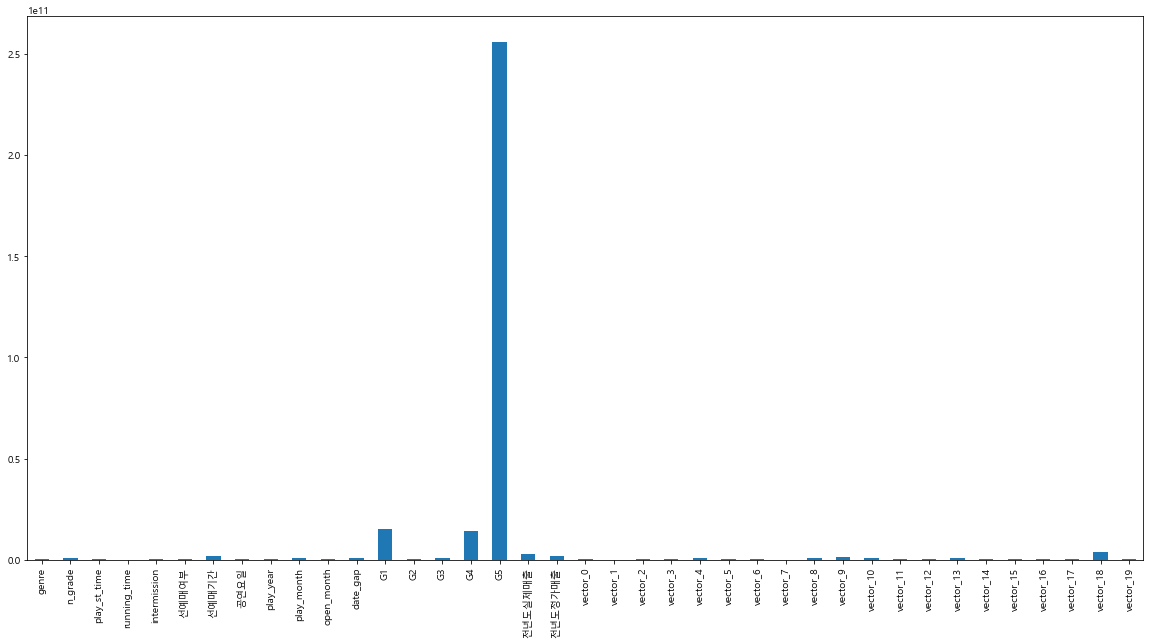

In [23]:
f_importance.plot.bar(figsize=(20,10), legend=False)
plt.show()

### Save Data

In [ ]:
# feature.to_parquet('../data/feature_price_0918.pqt')

In [ ]:
# 기대매출
# 예상 초대권 사용(?), 예상 할인적용률(?)